# Feature Engineering for Fraudulent Review Detection  
This notebook performs end-to-end feature engineering for the BT4012 fraud detection project.  
We engineer features from three major data sources:

1. **Reviewer (User) Data**  
   - Historical behaviour and engagement patterns  
   - Account age and activity frequency  
   - Normalised ratios such as useful_per_review and reviews_per_month  
   - These features help identify suspicious user behaviour (e.g., very new accounts posting frequent reviews)

2. **Business (Restaurant) Data**  
   - Restaurant attributes, operational characteristics, and completeness of business profiles  
   - Category signals and filtered-review statistics  
   - Top-5 categorical encoding is used to prevent sparsity from exploding one-hot encodings

3. **Reviewer–Business Relationship Features**  
   - Geographic match (same city/state)  
   - Exact location matching  
   - These features detect unusual patterns, such as users reviewing restaurants far outside their typical region

4. **Graph-Based Network Features**  
   - Reviewer graph constructed using shared restaurants  
   - Edge weights represent co-review frequency  
   - Extracted features include `max_weight`, `avg_weight`, and `clustering_coeff`  
   - This captures fraud rings, where multiple fake accounts target the same businesses

---

## Objective  
The goal of this notebook is to produce a **single, unified, feature-rich dataset** that captures behavioural, business, relational, and network-level characteristics for each review instance.

This dataset will be used to train downstream machine learning models for detecting fraudulent reviews.


In [1]:
# Imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


c:\Users\Andrew Chong\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:
path_reviewers = "../data/raw/Reviewers (Users) CSV.csv"
path_reviews = "../data/raw/Smaller_Reviews.csv"
path_restaurants = "../data/raw/Resturants CSV.csv"

# Load data
reviewers = pd.read_csv(path_reviewers)
reviews = pd.read_csv(path_reviews)
restaurants = pd.read_csv(path_restaurants)

# Columns that should remain un-prefixed
exclude = ['reviewID', 'reviewerID', 'restaurantID']

# Apply prefixes for column origin traceability
reviews.columns = [c if c in exclude else f"review_{c}" for c in reviews.columns]
reviewers.columns = [c if c in exclude else f"reviewer_{c}" for c in reviewers.columns]
restaurants.columns = [c if c in exclude else f"restaurant_{c}" for c in restaurants.columns]


In [3]:
# Convert dates
reviews['review_date'] = pd.to_datetime(reviews['review_date'], errors='coerce')
reviewers['reviewer_yelpJoinDate'] = pd.to_datetime(
    reviewers['reviewer_yelpJoinDate'], format="%B %Y", errors='coerce'
)

# Split reviewer location into city/state
loc_split = reviewers['reviewer_location'].str.split(",", n=1, expand=True)
reviewers['reviewer_city'] = loc_split[0].str.strip()
reviewers['reviewer_state'] = loc_split[1].str.strip()


In [4]:
#Merge 
df = (
    reviews
    .merge(reviewers, on="reviewerID", how="left")
    .merge(restaurants, on="restaurantID", how="left")
)


## Feature Engineering for Reviewers

In [5]:
# Account age
df['account_age_days'] = (df['review_date'] - df['reviewer_yelpJoinDate']).dt.days
df['account_age_months'] = (df['account_age_days'] / 30).clip(lower=0)

# Safe denominator
safe_review_count = df['reviewer_reviewCount'].replace(0, np.nan)

# Reviewer activity
df['reviews_per_month'] = df['reviewer_reviewCount'] / df['account_age_months']

# Per-review ratios
ratio_cols = [
    "usefulCount", "coolCount", "funnyCount",
    "complimentCount", "tipCount", "fanCount", "firstCount"
]

for metric in ratio_cols:
    colname = f"reviewer_{metric}"
    if colname in df.columns:
        df[f"{metric}_per_review"] = df[colname] / safe_review_count

# Engagement ratio
df['engagement_ratio'] = (
    df['reviewer_usefulCount'] +
    df['reviewer_coolCount'] +
    df['reviewer_funnyCount']
) / safe_review_count


## Feature Engineering for Businesses

In [6]:
# Clean restaurant location → extract city/state
parts = df['restaurant_location'].fillna("").str.split("-")

def get_city_state(x):
    last = x[-1].strip()
    if ", " in last:
        return last.split(", ")
    return (None, None)

df['restaurant_city'], df['restaurant_state'] = zip(*parts.apply(get_city_state))

def get_neighbourhood(x):
    return x[-2].strip() if len(x) >= 2 else None

df['restaurant_neighbourhood'] = parts.apply(get_neighbourhood)

# Missing fields count
business_cols = [c for c in df.columns if c.startswith("restaurant_")]
df["restaurant_num_missing_fields"] = df[business_cols].isna().sum(axis=1)

# Feature availability count
restaurant_feature_cols = [
    "restaurant_GoodforKids", "restaurant_AcceptsCreditCards", "restaurant_Parking",
    "restaurant_Attire", "restaurant_GoodforGroups", "restaurant_PriceRange",
    "restaurant_TakesReservations", "restaurant_Delivery", "restaurant_Takeout",
    "restaurant_WaiterService", "restaurant_OutdoorSeating", "restaurant_WiFi",
    "restaurant_Alcohol", "restaurant_NoiseLevel", "restaurant_Ambience",
    "restaurant_HasTV", "restaurant_Caters", "restaurant_WheelchairAccessible"
]

df['restaurant_feature_count'] = df[restaurant_feature_cols].notna().sum(axis=1)

# Fill numeric missing values
num_cols = ['restaurant_reviewCount', 'restaurant_rating', 'restaurant_filReviewCount']
df[num_cols] = df[num_cols].fillna(0)

# Filtered reviews
df['restaurant_filtered_ratio'] = df['restaurant_filReviewCount'] / (df['restaurant_reviewCount'] + 1)
df['restaurant_filtered_diff'] = df['restaurant_reviewCount'] - df['restaurant_filReviewCount']


In [7]:
# Removing Unneccesary Business Columns 
cols_to_remove_before_any_processing = [
"restaurant_name",
"restaurant_address",
"restaurant_phoneNumber",
"restaurant_location",
"restaurant_Hours",
"restaurant_categories",
"restaurant_webSite",

]

df = df.drop(columns=cols_to_remove_before_any_processing, errors="ignore")

## Reviewer–Restaurant Geographic Consistency Features


In [8]:
df['same_state'] = (df['reviewer_state'] == df['restaurant_state']).astype(int)
df['same_city'] = (df['reviewer_city'] == df['restaurant_city']).astype(int)
df['location_exact_match'] = (df['same_city'] & df['same_state']).astype(int)

#Geographical signals are a powerful tool in detecting suspicious reviewers.  
#Legitimate users typically review restaurants located within reasonable proximity to
#where they live, while fraudulent accounts often exhibit patterns that contradict 
#normal geographic behaviour.



### Perform One Hot Encoding for model training

We do OHE for location based features because fraud reviews could be more rampant in certain restaurant locations.

In [9]:
restaurant_object_cols = df[[c for c in df.columns if c.startswith("restaurant_")]].select_dtypes(include="object").columns.tolist()

for col in restaurant_object_cols:
    top5 = df[col].value_counts().nlargest(5).index
    df[col + "_top5"] = df[col].where(df[col].isin(top5), "Others")

df = pd.get_dummies(df, columns=[c + "_top5" for c in restaurant_object_cols])

df.drop(columns=restaurant_object_cols, inplace=True)


In [10]:
#removed:
#"review_Unnamed: 0","review_date","reviewID","reviewerID","review_reviewContent","review_rating",
#"review_flagged","restaurantID","reviewer_name","reviewer_location","reviewer_yelpJoinDate",
#"reviewer_city","reviewer_state","account_age_days",


business_and_reviewers_feature_list = [
    "review_flagged",
    "review_rating",
    "review_usefulCount",
    "review_coolCount",
    "review_funnyCount",
    "reviewer_friendCount",
    "reviewer_reviewCount",
    "reviewer_firstCount",
    "reviewer_usefulCount",
    "reviewer_coolCount",
    "reviewer_funnyCount",
    "reviewer_complimentCount",
    "reviewer_tipCount",
    "reviewer_fanCount",
    "reviews_per_month",
    "usefulCount_per_review",
    "coolCount_per_review",
    "funnyCount_per_review",
    "complimentCount_per_review",
    "tipCount_per_review",
    "fanCount_per_review",
    "firstCount_per_review",
    "engagement_ratio",
    "account_age_months",
    "restaurant_reviewCount",
    "restaurant_rating",
    "restaurant_filReviewCount",
    "restaurant_num_missing_fields",
    "restaurant_feature_count",
    "restaurant_filtered_ratio",
    "restaurant_filtered_diff",

    "same_state",
    "same_city",
    "location_exact_match",

    "restaurant_GoodforKids_top5_No",
    "restaurant_GoodforKids_top5_Others",
    "restaurant_GoodforKids_top5_Yes",
    "restaurant_AcceptsCreditCards_top5_No",
    "restaurant_AcceptsCreditCards_top5_Others",
    "restaurant_AcceptsCreditCards_top5_Yes",
    "restaurant_Parking_top5_Others",
    "restaurant_Parking_top5_Private Lot",
    "restaurant_Parking_top5_Street",
    "restaurant_Parking_top5_Street, Private Lot",
    "restaurant_Parking_top5_Street, Valet",
    "restaurant_Parking_top5_Valet",
    "restaurant_Attire_top5_Casual",
    "restaurant_Attire_top5_Dressy",
    "restaurant_Attire_top5_Formal (Jacket Required)",
    "restaurant_Attire_top5_Others",
    "restaurant_GoodforGroups_top5_No",
    "restaurant_GoodforGroups_top5_Others",
    "restaurant_GoodforGroups_top5_Yes",
    "restaurant_PriceRange_top5_$",
    "restaurant_PriceRange_top5_$$",
    "restaurant_PriceRange_top5_$$$",
    "restaurant_PriceRange_top5_$$$$",
    "restaurant_PriceRange_top5_Others",
    "restaurant_PriceRange_top5_££",
    "restaurant_TakesReservations_top5_No",
    "restaurant_TakesReservations_top5_Others",
    "restaurant_TakesReservations_top5_Yes",
    "restaurant_Delivery_top5_No",
    "restaurant_Delivery_top5_Others",
    "restaurant_Delivery_top5_Yes",
    "restaurant_Takeout_top5_No",
    "restaurant_Takeout_top5_Others",
    "restaurant_Takeout_top5_Yes",
    "restaurant_WaiterService_top5_No",
    "restaurant_WaiterService_top5_Others",
    "restaurant_WaiterService_top5_Yes",
    "restaurant_OutdoorSeating_top5_No",
    "restaurant_OutdoorSeating_top5_Others",
    "restaurant_OutdoorSeating_top5_Yes",
    "restaurant_WiFi_top5_Free",
    "restaurant_WiFi_top5_No",
    "restaurant_WiFi_top5_Others",
    "restaurant_WiFi_top5_Paid",
    "restaurant_GoodFor_top5_Breakfast",
    "restaurant_GoodFor_top5_Dinner",
    "restaurant_GoodFor_top5_Late Night, Dinner",
    "restaurant_GoodFor_top5_Lunch",
    "restaurant_GoodFor_top5_Lunch, Dinner",
    "restaurant_GoodFor_top5_Others",
    "restaurant_Alcohol_top5_Beer & Wine Only",
    "restaurant_Alcohol_top5_Full Bar",
    "restaurant_Alcohol_top5_No",
    "restaurant_Alcohol_top5_Others",
    "restaurant_NoiseLevel_top5_Average",
    "restaurant_NoiseLevel_top5_Loud",
    "restaurant_NoiseLevel_top5_Others",
    "restaurant_NoiseLevel_top5_Quiet",
    "restaurant_NoiseLevel_top5_Very Loud",
    "restaurant_Ambience_top5_Casual",
    "restaurant_Ambience_top5_Classy",
    "restaurant_Ambience_top5_Hipster, Casual",
    "restaurant_Ambience_top5_Others",
    "restaurant_Ambience_top5_Trendy",
    "restaurant_Ambience_top5_Trendy, Casual",
    "restaurant_HasTV_top5_No",
    "restaurant_HasTV_top5_Others",
    "restaurant_HasTV_top5_Yes",
    "restaurant_Caters_top5_No",
    "restaurant_Caters_top5_Others",
    "restaurant_Caters_top5_Yes",
    "restaurant_WheelchairAccessible_top5_No",
    "restaurant_WheelchairAccessible_top5_Others",
    "restaurant_WheelchairAccessible_top5_Yes",
    "restaurant_city_top5_Chicago",
    "restaurant_city_top5_Las Vegas",
    "restaurant_city_top5_Los Angeles",
    "restaurant_city_top5_New York",
    "restaurant_city_top5_Others",
    "restaurant_city_top5_San Francisco",
    "restaurant_state_top5_CA",
    "restaurant_state_top5_IL",
    "restaurant_state_top5_MA",
    "restaurant_state_top5_NY",
    "restaurant_state_top5_Others",
    "restaurant_state_top5_TX",
    "restaurant_neighbourhood_top5_Lakeview",
    "restaurant_neighbourhood_top5_Lincoln Park",
    "restaurant_neighbourhood_top5_Near North Side",
    "restaurant_neighbourhood_top5_Others",
    "restaurant_neighbourhood_top5_The Loop",
    "restaurant_neighbourhood_top5_Wicker Park",
]


## Graph-Based Reviewer Network Features

To capture coordinated behaviour among suspicious reviewers, we construct a
reviewer–reviewer interaction graph based on shared restaurant activity.

Fake-review campaigns often involve multiple accounts operated by the same entity,
leaving behind a structural footprint in the form of tightly connected reviewer clusters.
This section transforms raw reviewer–restaurant interactions into graph-theoretic
features that quantify these relationships.


In [11]:
# Initialise an undirected graph. Reviewers will be the vertices, and the edges will be the restaurants used
graph = nx.Graph()


# Add the reviewers as the vertices
graph.add_nodes_from(df['reviewerID'].unique())


# Build graph edges using shared restaurants (if 2 reviewers have the same shared restaurants, add 1 to the list)
restaurant_groupby_df = df.groupby('restaurantID')['reviewerID'].apply(list)

for reviewer_list in restaurant_groupby_df:
    for i in range(len(reviewer_list)):
        for j in range(i + 1, len(reviewer_list)):
            reviewer_1 = reviewer_list[i]
            reviewer_2 = reviewer_list[j]
            if graph.has_edge(reviewer_1, reviewer_2):
                graph[reviewer_1][reviewer_2]['weight'] += 1
            else:
                graph.add_edge(reviewer_1, reviewer_2, weight = 1)


# We hypothesise that fake review companies are likely to use multiple accounts to comment on the same set of restaurants.
# Hence, we believe that accounts with many fake reviews are likely to operate closely in tight clusters, therefore we believe that these accounts are likely to have a higher clustering coefficient. 
# Because the clusters are tight, we also believe that the centrality will be higher for fake review accounts.
# Lastly, we calculate the pagerank (expect accounts with many fake reviews to have higher pagerank score due to the tight cluster hypothesis)

max_weight = {}
avg_weight = {}
for node in graph.nodes():
    weights = [graph[node][neighbour]['weight'] for neighbour in graph.neighbors(node)]
    max_weight[node] = max(weights) if weights else 0
    avg_weight[node] = np.mean(weights) if weights else 0

clustering = nx.clustering(graph, weight = 'weight')
deg_cent = nx.degree_centrality(graph)
pagerank = nx.pagerank(graph, weight = 'weight')

graph_features = pd.DataFrame({
    'reviewerID': list(graph.nodes()),
    'max_weight': [max_weight[n] for n in graph.nodes()],
    'avg_weight': [avg_weight[n] for n in graph.nodes()],
    'clustering_coeff': [clustering[n] for n in graph.nodes()],
    'unweighted_degree_centrality': [deg_cent[n] for n in graph.nodes()],
    'pagerank': [pagerank[n] for n in graph.nodes()]
})


#Store everything into merged df
graph_feature_list = ['max_weight', 'avg_weight', 'clustering_coeff', 'unweighted_degree_centrality', 'pagerank']
df = df.merge(graph_features, on = 'reviewerID', how = 'left')
df[graph_feature_list] = df[graph_feature_list].fillna(0)

print(df[graph_feature_list].head())


   max_weight  avg_weight  clustering_coeff  unweighted_degree_centrality  \
0           1     1.00000          0.031590                      0.001108   
1           1     1.00000          0.166667                      0.000123   
2           1     1.00000          0.166805                      0.011942   
3           2     1.00202          0.052913                      0.030471   
4           1     1.00000          0.166730                      0.006033   

   pagerank  
0  0.000075  
1  0.000034  
2  0.000079  
3  0.000318  
4  0.000067  


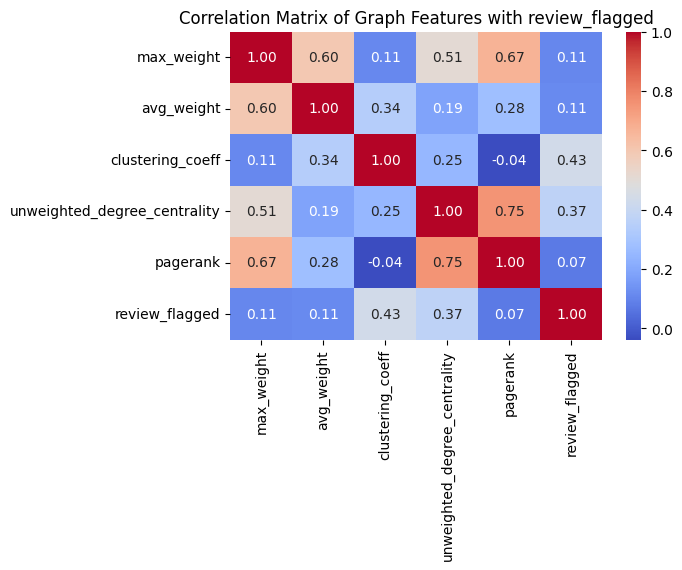

In [12]:
# Check if graph features do have the intended correlation 

graph_corr_matrix = df[graph_feature_list + ['review_flagged']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(graph_corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Matrix of Graph Features with review_flagged")
plt.show()

# Text features

In [13]:
def map_star_to_sentiment(stars: int) -> int:
    if stars <= 2:
        return 0   # negative
    elif stars == 3:
        return 1   # neutral
    else:
        return 2   # positive

# Ensure rating is integer and create rating_sent_class on df only
df["review_rating"] = df["review_rating"].astype(int)
df["rating_sent_class"] = df["review_rating"].apply(map_star_to_sentiment)

print(df[["review_rating", "rating_sent_class"]].head())

   review_rating  rating_sent_class
0              4                  2
1              3                  1
2              5                  2
3              5                  2
4              4                  2


In [14]:
# Loading trained RoBERTa sentiment analyser

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

c:\Users\Andrew Chong\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [15]:
def add_roberta_sentiment(df, text_col, batch_size, max_length, neutral_threshold = 0.25):
    """
    Add RoBERTa sentiment columns:
        sent_neg, sent_neu, sent_pos, sent_score,
        sent_label (0 means negative, 1 means neutral, 2 means positive),
        sent_label_score (thresholded via sent_score with [-0.25, 0.25] = neutral)
    """
    df = df.copy()
    texts = df[text_col].astype(str).tolist()

    all_neg = []
    all_neu = []
    all_pos = []
    all_score = []
    all_label = []

    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa sentiment"):
        batch_texts = texts[i : i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

        neg = probs[:, 0]
        neu = probs[:, 1]
        pos = probs[:, 2]
        score = pos - neg
        label = np.argmax(probs, axis=-1)

        all_neg.extend(neg)
        all_neu.extend(neu)
        all_pos.extend(pos)
        all_score.extend(score)
        all_label.extend(label)

    df["sent_neg"] = all_neg
    df["sent_neu"] = all_neu
    df["sent_pos"] = all_pos
    df["sent_score"] = all_score
    df["sent_label"] = all_label

    t = neutral_threshold
    df["sent_label_score"] = np.where(
        df["sent_score"] < -t,
        0,
        np.where(df["sent_score"] > t, 2, 1),
    )

    return df

df = add_roberta_sentiment(
    df,
    text_col = "review_reviewContent",
    batch_size = 32,
    max_length = 128,
)

RoBERTa sentiment: 100%|██████████| 1563/1563 [52:07<00:00,  2.00s/it]


In [16]:
# Absolute mismatch between star-based class and Roberta class
df["mismatch_class_abs"] = (
    (df["rating_sent_class"] - df["sent_label_score"]).abs()
)

print(df[["review_rating", "rating_sent_class", "sent_label_score", "mismatch_class_abs"]].head())

   review_rating  rating_sent_class  sent_label_score  mismatch_class_abs
0              4                  2                 2                   0
1              3                  1                 2                   1
2              5                  2                 2                   0
3              5                  2                 2                   0
4              4                  2                 2                   0


In [17]:
#Account Aggregation

account_sent = (
    df
    .groupby("reviewerID")
    .agg(
        account_sent_score_mean=("sent_score", "mean"),
        account_reviews_count=("reviewID", "nunique"),
        account_mismatch_class_abs_mean=("mismatch_class_abs", "mean")  # How often does user give stars that don’t match what they actually wrote
    )
    .reset_index()
)

df = df.merge(account_sent, on="reviewerID", how="left")
df["review_vs_account_score"] = (
    df["sent_score"] - df["account_sent_score_mean"]) # Is this review unusually positive (or negative) compared to what this user normally writes

print(df.head())

   review_Unnamed: 0 review_date                reviewID  \
0                  0  2008-11-14  NILB9aTWEwVmrw7MvHrhDw   
1                  1  2011-02-02  eedzlwLfJsVhd59JWtZK5A   
2                  2  2007-03-08  y8_FAOVmQP0F0vbhgxkWxg   
3                  3  2010-11-04  DkVYC6K9aQEFWztANoXlVw   
4                  4  2012-02-20  cnSCfLMZTQm0FBVzOFuiAg   

               reviewerID                               review_reviewContent  \
0  WI9UJah3bVB258wzEIh34A  Good food, cute ambiance, good drinks, a cool ...   
1  hSFZC_AG7OgVfeFTt6RBkQ  So we went shopping in the Design District and...   
2  S3Dnc8F00c4hk8lepYWz5Q     I liked it very much ! great food and service.   
3  qruOUB36ZPf9zztkemL2pw  I've been to a couple locations of Gymboree Pl...   
4  Ao2VYIw9AMKOTiCUwe_T9A  Diner type meals with an upgrade.  Both greek ...   

   review_rating  review_usefulCount  review_coolCount  review_funnyCount  \
0              4                   1                 4                  3   
1   

In [18]:
# Business Aggregation

business_sent = (
    df
    .groupby("restaurantID")
    .agg(
        business_sent_score_mean=("sent_score", "mean"),
        business_reviews_count=("reviewID", "nunique"),
        business_mismatch_class_abs_mean=("mismatch_class_abs", "mean"), # For each restaurant, the average disagreement between the star ratings and the RoBERTa sentiment of the review texts.
    )
    .reset_index()
)

df = df.merge(business_sent, on="restaurantID", how="left")

df["user_vs_business_sent_score"] = (
    df["sent_score"] - df["business_sent_score_mean"]
)

print(df.head())

   review_Unnamed: 0 review_date                reviewID  \
0                  0  2008-11-14  NILB9aTWEwVmrw7MvHrhDw   
1                  1  2011-02-02  eedzlwLfJsVhd59JWtZK5A   
2                  2  2007-03-08  y8_FAOVmQP0F0vbhgxkWxg   
3                  3  2010-11-04  DkVYC6K9aQEFWztANoXlVw   
4                  4  2012-02-20  cnSCfLMZTQm0FBVzOFuiAg   

               reviewerID                               review_reviewContent  \
0  WI9UJah3bVB258wzEIh34A  Good food, cute ambiance, good drinks, a cool ...   
1  hSFZC_AG7OgVfeFTt6RBkQ  So we went shopping in the Design District and...   
2  S3Dnc8F00c4hk8lepYWz5Q     I liked it very much ! great food and service.   
3  qruOUB36ZPf9zztkemL2pw  I've been to a couple locations of Gymboree Pl...   
4  Ao2VYIw9AMKOTiCUwe_T9A  Diner type meals with an upgrade.  Both greek ...   

   review_rating  review_usefulCount  review_coolCount  review_funnyCount  \
0              4                   1                 4                  3   
1   

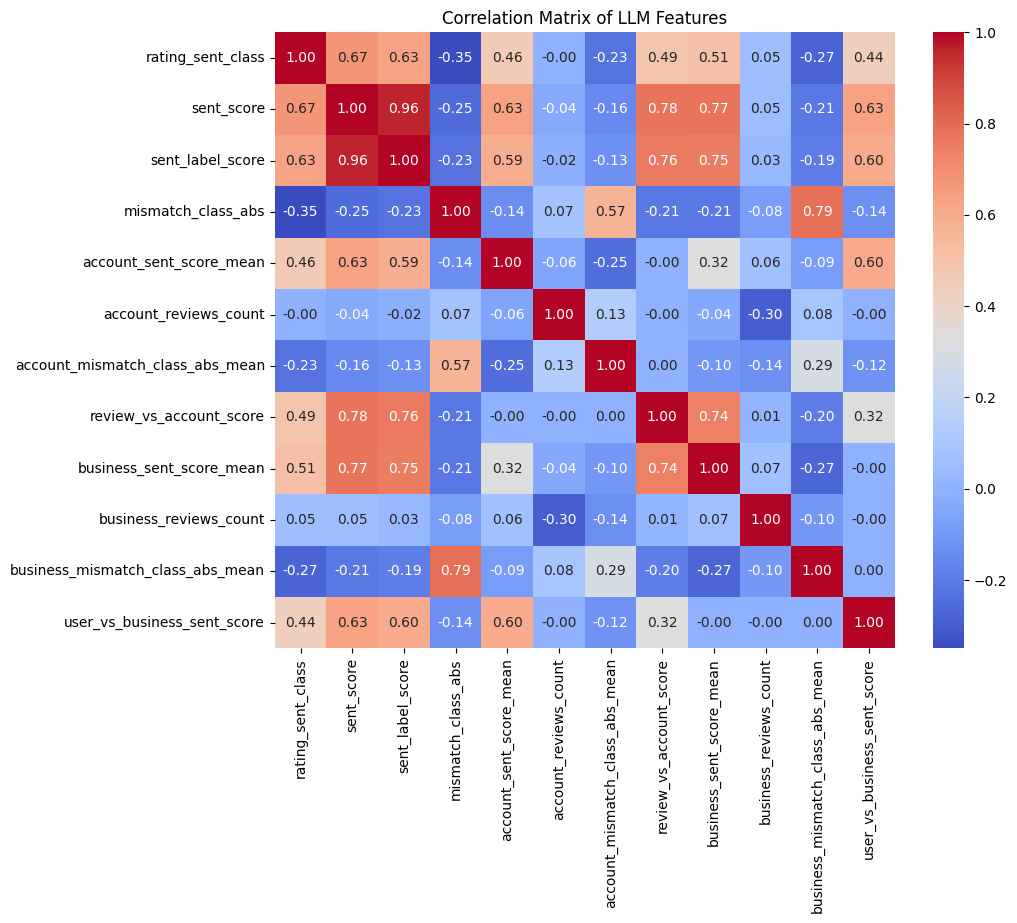

In [19]:
text_features_col = [
    "rating_sent_class",
    "sent_score",
    "sent_label_score",
    "mismatch_class_abs",
    "account_sent_score_mean",
    "account_reviews_count",
    "account_mismatch_class_abs_mean",
    "review_vs_account_score",
    "business_sent_score_mean",
    "business_reviews_count",
    "business_mismatch_class_abs_mean",
    "user_vs_business_sent_score"
]

cols_present = [c for c in text_features_col if c in df.columns]
features_df = df[cols_present].copy()

for c in cols_present:
    features_df[c] = pd.to_numeric(features_df[c], errors="coerce")

corr_matrix = features_df.corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Correlation Matrix of LLM Features")
plt.show()

# Train test split

In [20]:
df = df[business_and_reviewers_feature_list + graph_feature_list + text_features_col]
X = df.drop(columns=['review_flagged'])
y = df['review_flagged']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_df = X_train.copy()
train_df["review_flagged"] = y_train 

test_df = X_test.copy()
test_df["review_flagged"] = y_test

train_df.to_csv("../data/processed/train.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)
